# Visualizing and Analyzing Features

In [1]:
# Importing all the libraries we need or may need

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

import pickle

# Loading Dataset to Run Visual Analyses

### We've decided to dig a little further to see what we can learn about our (now smaller) dataset. First we replace the features containing string objects as we did before, and then take the indices from the smaller dataset and apply them to the original traiing set.

In [2]:
df = pd.read_csv('/content/drive/My Drive/ai_project_2021/train.csv', index_col = 'id')

In [3]:
cleanup_categories = {'Gender': {'Male': 0, 'Female': 1},
                      'Vehicle_Age': {'< 1 Year': 0, '1-2 Year': 0.5, '> 2 Years': 1},
                      'Vehicle_Damage': {'Yes': 1, 'No': 0}}

In [4]:
df = df.replace(cleanup_categories)
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,0,44,1,28.0,0,1.0,1,40454.0,26.0,217,1
2,0,76,1,3.0,0,0.5,0,33536.0,26.0,183,0
3,0,47,1,28.0,0,1.0,1,38294.0,26.0,27,1
4,0,21,1,11.0,1,0.0,0,28619.0,152.0,203,0
5,1,29,1,41.0,1,0.0,0,27496.0,152.0,39,0


In [5]:
df_smaller = pd.read_csv('/content/drive/My Drive/ai_project_2021/df_smaller1.csv', index_col='Unnamed: 0')

In [6]:
# Keeping only the indices from the smaller DataFrame

df = df[df.index.isin(df_smaller.index)]

In [7]:
df['Response']

id
1         1
2         0
5         0
6         0
7         0
         ..
381099    0
381100    0
381101    0
381103    0
381108    0
Name: Response, Length: 178047, dtype: int64

# Describing the data, checking feature distributions and checking feature correlation.

In [8]:
# Print the shape of the data

print(df.shape)
print(df.describe())

(178047, 11)
              Gender            Age  ...        Vintage       Response
count  178047.000000  178047.000000  ...  178047.000000  178047.000000
mean        0.459070      38.813336  ...     154.482861       0.122552
std         0.498323      15.512818  ...      83.517063       0.327923
min         0.000000      20.000000  ...      10.000000       0.000000
25%         0.000000      25.000000  ...      82.000000       0.000000
50%         0.000000      36.000000  ...     155.000000       0.000000
75%         1.000000      49.000000  ...     227.000000       0.000000
max         1.000000      85.000000  ...     299.000000       1.000000

[8 rows x 11 columns]


### Here we check the feature distribution in our new dataset

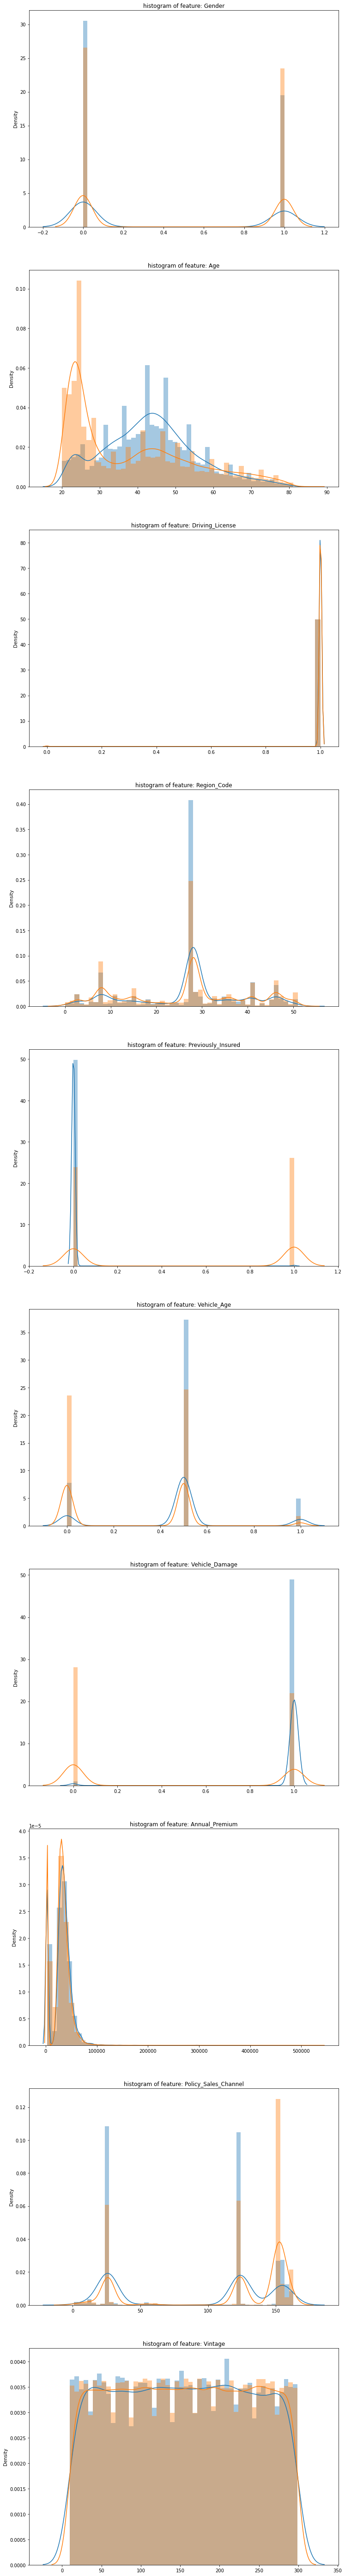

In [9]:
# distribution of features

features = df.iloc[:,0:-1].columns

plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(df.shape[1], 1)
for i, c in enumerate(df[features]):
 ax = plt.subplot(gs[i])
 sns.distplot(df[c][df.iloc[:,-1] == 1], bins=50)
 sns.distplot(df[c][df.iloc[:,-1] == 0], bins=50)
 ax.set_xlabel('')
 ax.set_title('histogram of feature: ' + str(c))
plt.show()

### Here we are plotting the features against themselves in order to see if anything jumps out at us visually.

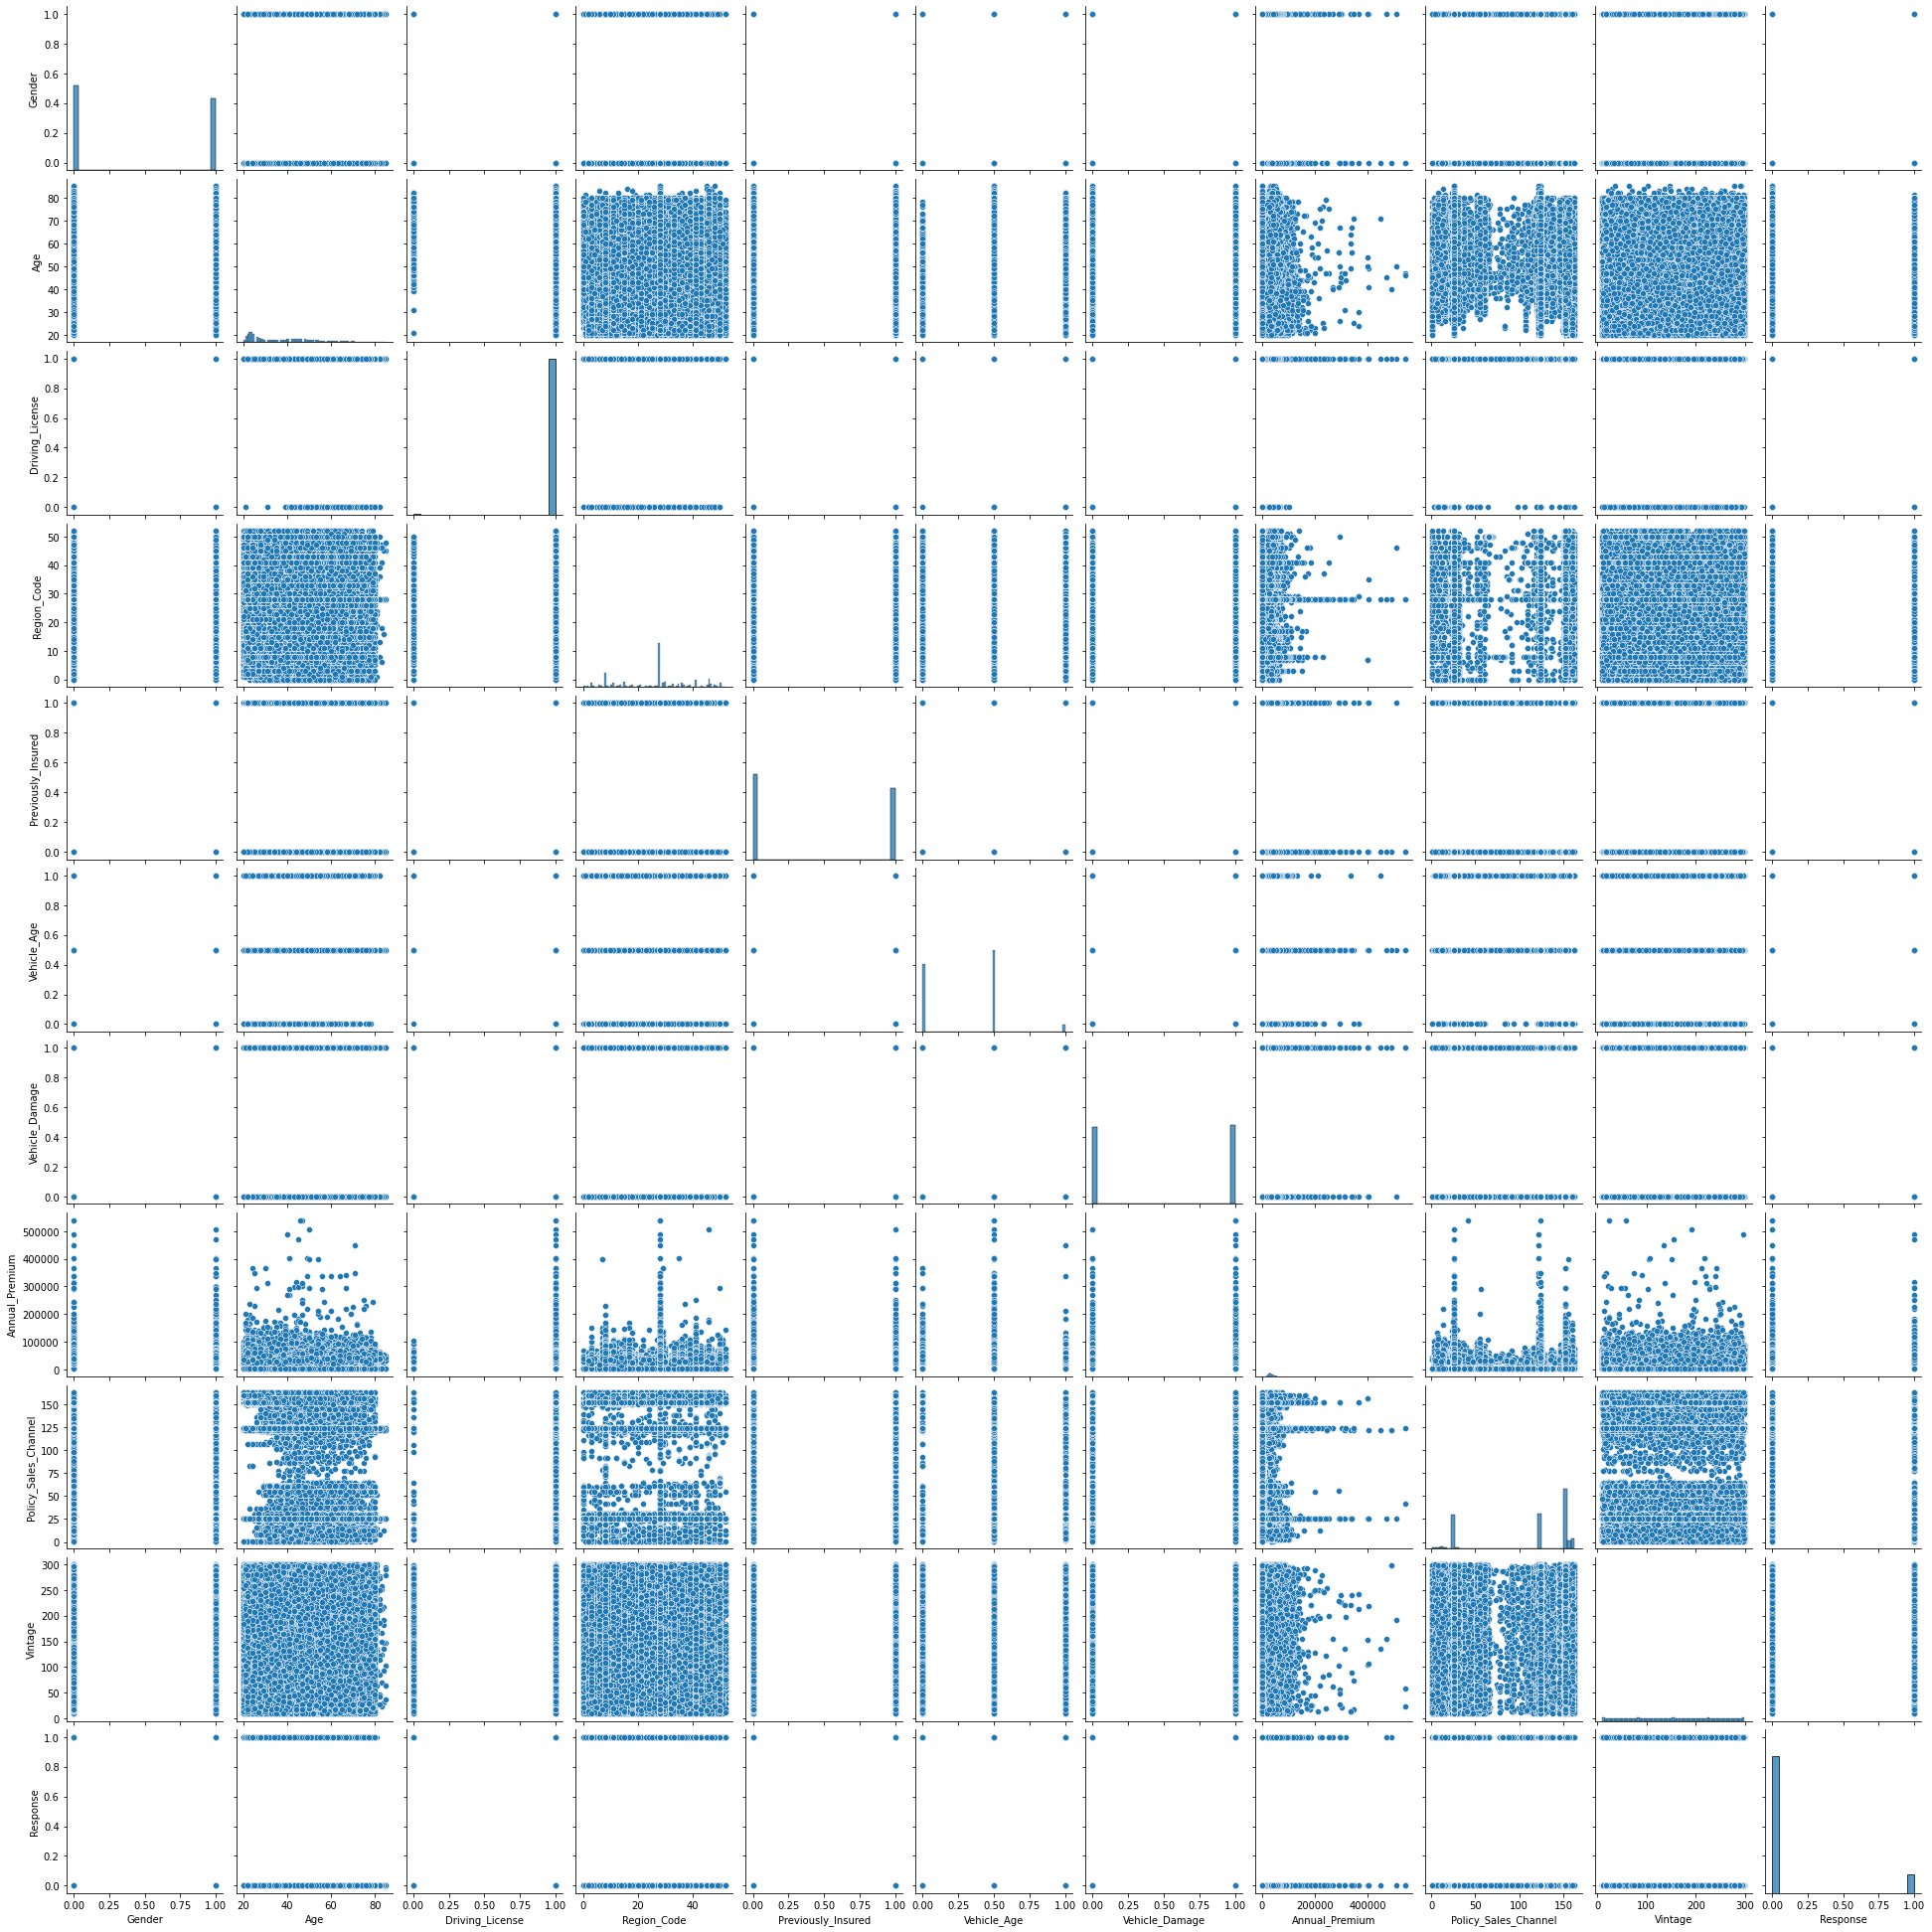

In [10]:
sns.pairplot(df)

### There isn't really anything that jumps out as being particularly useful or exploitable. Maybe with more time, but not for this project.

### Below is not a function we wrote ourselves. It looks complex, but in reality its only purpose is to show the correlation squares in a size proportional to their value in order to make it easier to see. Sometimes small changes in color gradient is not as useful on its own. 

In [11]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

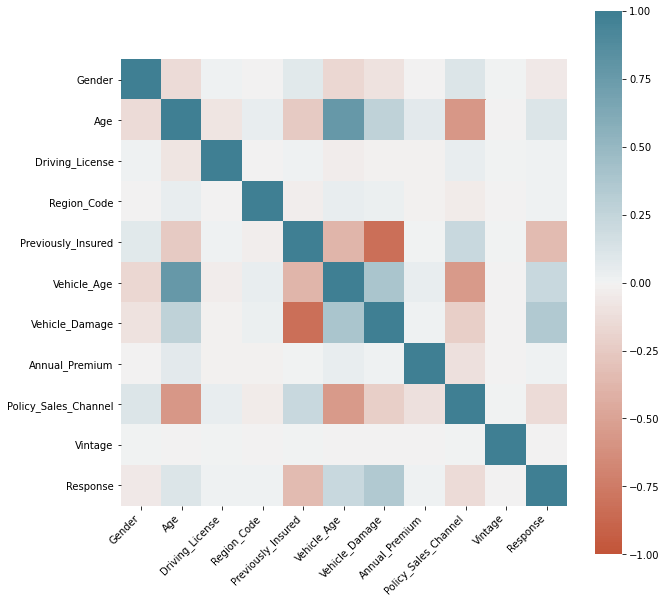

In [12]:
corr = df.corr()
plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### We can see below that unfortunately no features are strongly correlated with the classification 

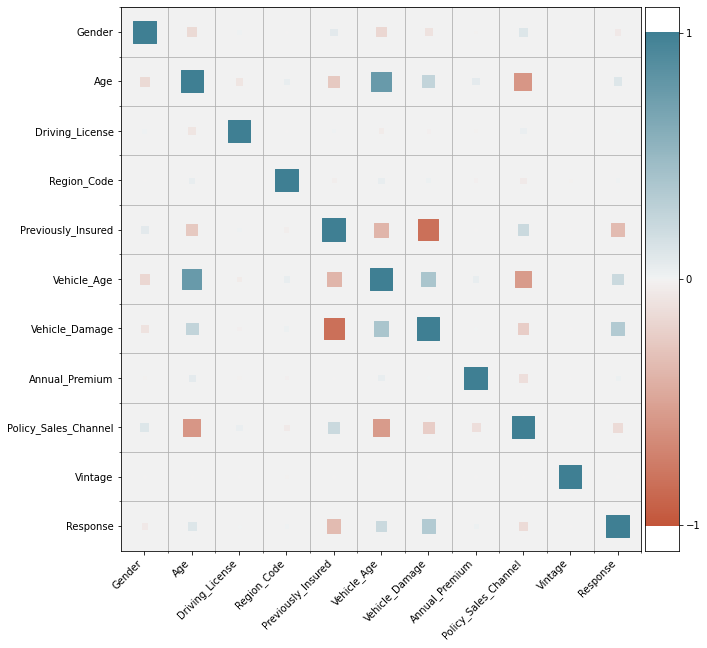

In [13]:
plt.figure(figsize=(10, 10))
corrplot(corr)

# Feature Importance Analysis

In [14]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 14, 7
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

In [15]:
# define dataset
X = df.iloc[:,:df.shape[1]-1]
y = df.iloc[:,df.shape[1]-1]

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)

### Here we have feature importance for classification by logistic regression.

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

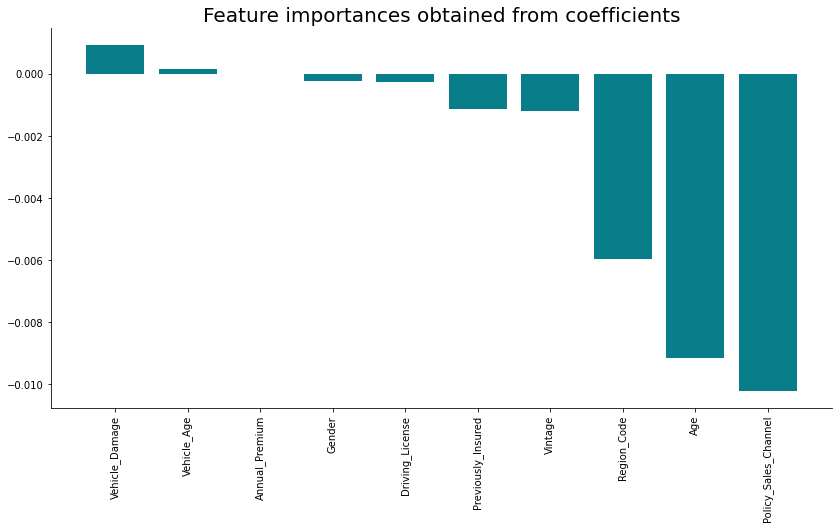

In [17]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

### Here we have feature importance for XGBoost classification.

In [18]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

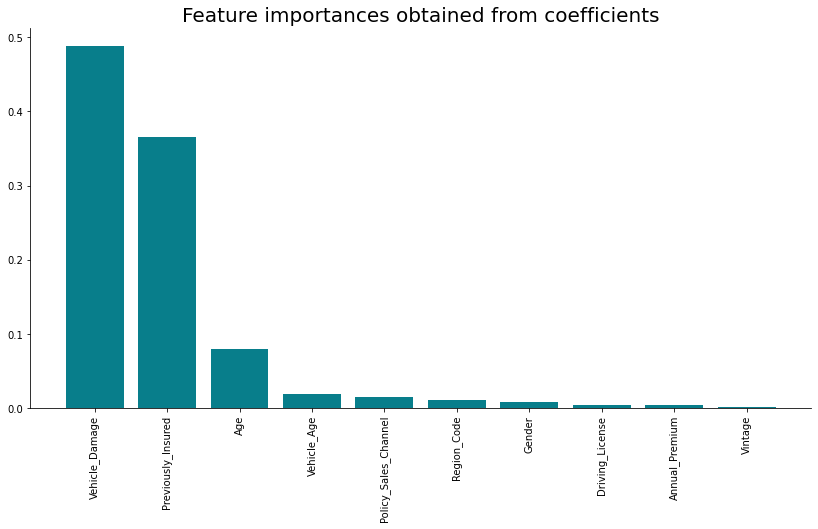

In [19]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

### Here we run a Principal Component Analysis. We see that a minuscule portion of the variance can mostly be explained by two features, but that does very little for us. 

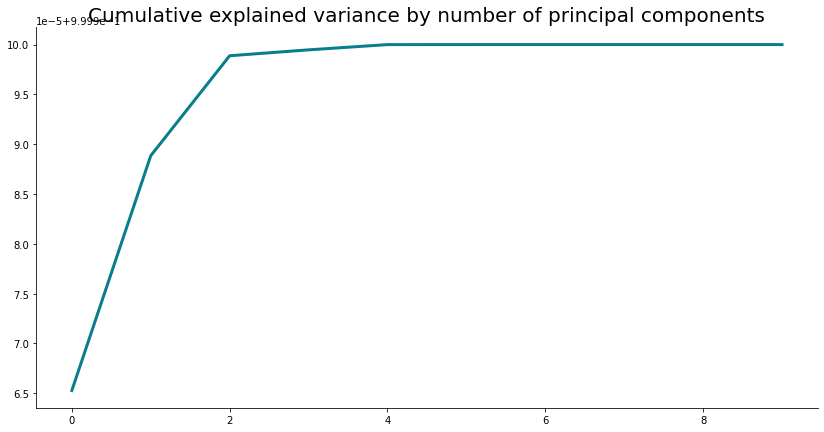

In [20]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

In [21]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(X_train.columns) + 1)],
    index=X_train.columns
)

loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Gender,-0.001901,0.001550,0.058400,0.006481,-0.047409,6.040558e-02,4.887878e-01,-1.862959e-03,3.666808e-03,4.261320e-05
Age,1.073660,-0.029219,-9.375727,-2.328888,12.100872,6.854707e-03,1.588393e-03,1.774015e-04,-1.910525e-03,-1.799025e-05
Driving_License,-0.000507,0.000147,0.002046,0.000488,-0.003126,-2.701331e-04,3.474451e-04,-2.919155e-05,1.896676e-03,-4.673160e-02
Region_Code,-0.160235,-0.066676,-0.635589,-13.010152,-2.256731,4.213632e-04,-1.227663e-04,1.306677e-05,-2.334277e-05,3.057018e-07
Previously_Insured,0.002288,0.000674,0.113970,0.019304,-0.071532,4.544021e-01,-3.568612e-02,-1.484400e-01,5.947071e-03,7.153160e-06
Vehicle_Age,0.012378,-0.001168,-0.161745,-0.030747,0.146756,-5.956984e-02,-6.596756e-03,-8.383221e-03,1.679315e-01,5.237869e-04
Vehicle_Damage,0.004937,-0.000930,-0.115667,-0.021751,0.078736,-4.550054e-01,3.013921e-02,-1.473903e-01,-1.559001e-02,-2.830066e-05
Annual_Premium,17202.474287,0.000712,0.020161,-0.000180,-0.000015,-6.646895e-07,-9.471403e-08,5.891199e-08,4.674376e-08,-5.809089e-10
Policy_Sales_Channel,-6.274749,0.204793,53.685634,-0.560960,2.087402,-9.880638e-04,-1.349816e-04,5.476154e-06,1.217416e-04,9.891248e-08
Vintage,-0.130949,83.512911,-0.135443,-0.009827,-0.002682,-5.526916e-06,-7.752763e-06,-4.673525e-07,1.069928e-06,8.204566e-08


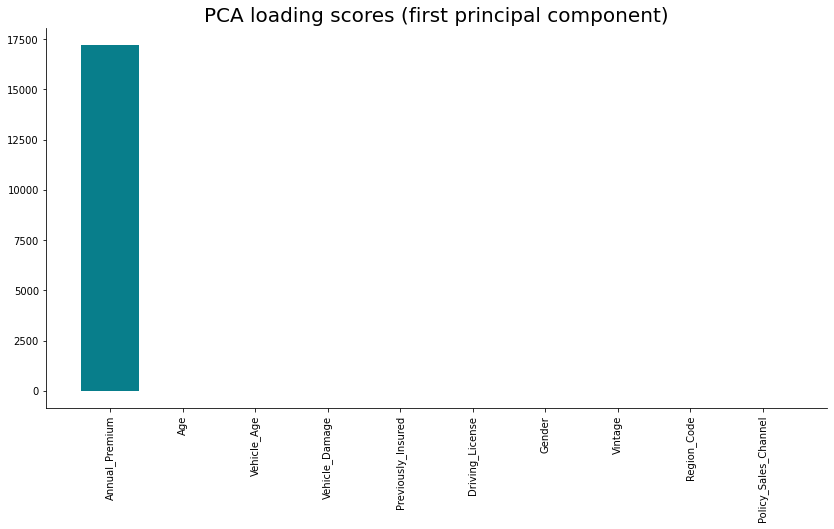

In [22]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

### Here we run the same analyses on feature importance but after scaling our features using MinMaxScaler.

In [23]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df))

In [24]:
# define dataset
X = df.iloc[:,:df.shape[1]-1]
y = df.iloc[:,df.shape[1]-1]

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)

In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

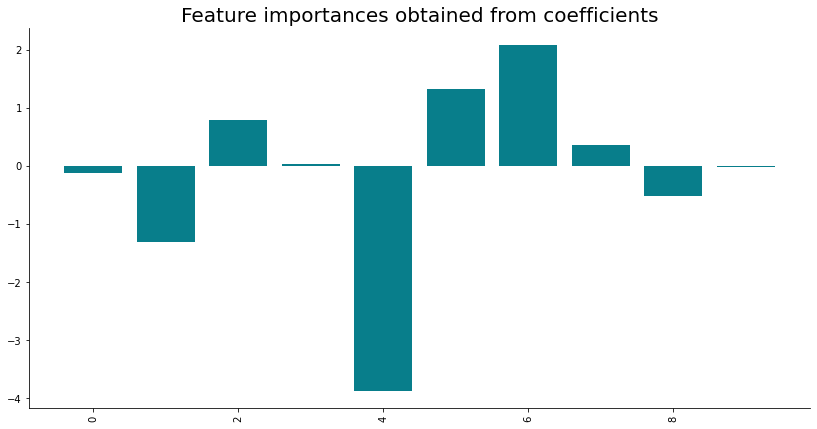

In [26]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [27]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

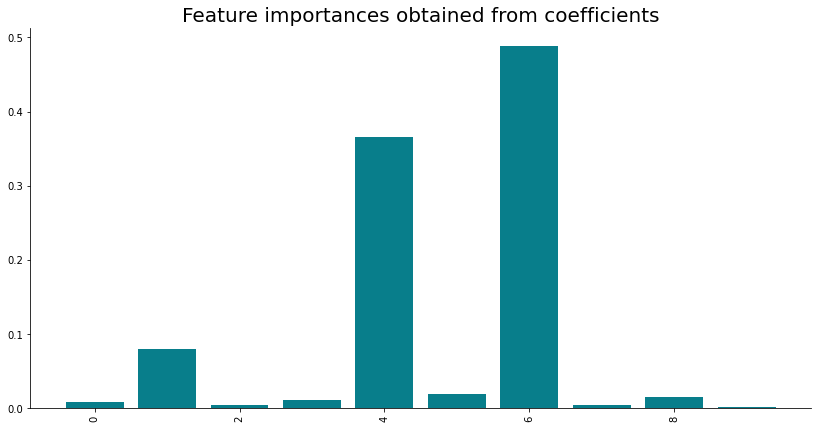

In [28]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

### We can see here that almost 90% of the variance can be expained by 4 features in this case. Once again, this would be very interesting to explore further with more time. However, we will continue with our strategy of attempting to cluster and then modelling the cluster classifications.

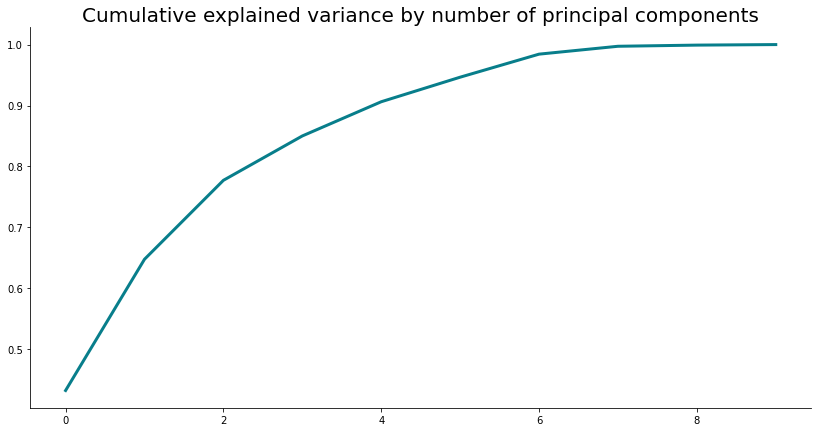

In [29]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

In [30]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(X_train.columns) + 1)],
    index=X_train.columns
)

loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.113480,0.477270,0.087064,-0.000540,0.001724,0.006086,-0.000849,-0.000158,0.000041,-0.000015
1,0.102963,-0.043587,0.166325,0.000891,0.004596,0.080119,-0.036004,0.095480,-0.001309,-0.000171
2,-0.001309,0.001005,-0.002194,0.000128,-0.000164,-0.000768,0.000286,-0.003648,-0.046696,0.000180
3,0.010018,-0.000419,0.017352,-0.005115,-0.253391,-0.002475,-0.000675,0.000049,0.000018,0.000068
4,-0.462034,-0.081864,0.078047,-0.000202,-0.001498,0.070650,0.130528,-0.003086,0.000008,-0.000102
5,0.158926,-0.044232,0.178735,0.000276,0.004705,0.115342,-0.050582,-0.074949,0.000607,0.000176
6,0.465909,0.075044,-0.072576,-0.000288,-0.001050,0.052409,0.138750,0.003441,-0.000031,-0.000067
7,0.000652,-0.000537,0.003207,-0.000026,0.000655,-0.001509,0.001485,0.000856,0.000254,0.031740
8,-0.128914,0.055095,-0.264082,-0.000799,-0.010131,0.136834,-0.056775,0.007544,0.000002,0.000383
9,-0.000718,0.001230,-0.000960,0.288932,-0.004532,0.000091,0.000218,-0.000199,0.000025,0.000005


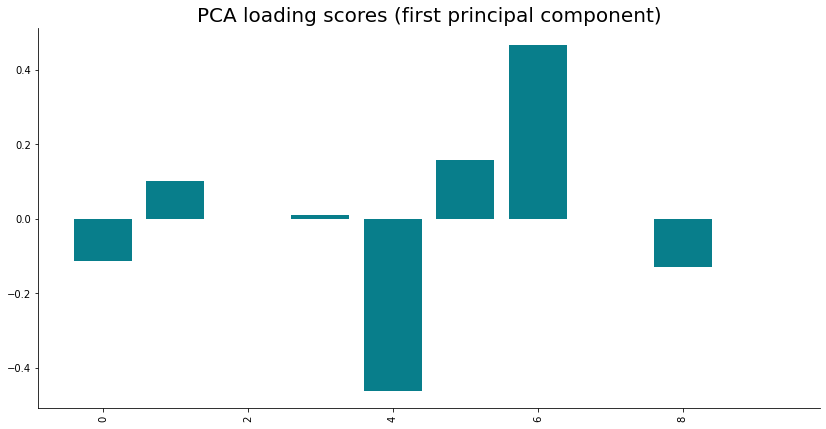

In [31]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()